In [178]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.1+cu118


In [179]:
#Installing dependencies
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install captum

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1+cu118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-q5u4tbv3
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-q5u4tbv3
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9bc70173159b44502d6908c1563cf8a72cac5cdb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [180]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.explain import CaptumExplainer, Explainer
from torch_geometric.nn import SAGEConv, to_hetero
import matplotlib.pyplot as plt
import numpy as np

In [181]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = IMDB(root='./data')
data = dataset[0].to(device)
data = T.ToUndirected()(data)
#print(data)

In [182]:
del data['actor']  # Deleting the unwanted nodes and edges
del data['movie', 'rev_to', 'director']
del data['movie', 'to', 'actor']
del data['director', 'to', 'movie']
del data['actor', 'to', 'movie']
del data['actor', 'rev_to', 'movie']
del data['movie', 'rev_to', 'actor']
del data['movie'].y
del data['movie'].train_mask
del data['movie'].val_mask
del data['movie'].test_mask

#print(data)

In [183]:
data['director', 'rev_to', 'movie'].edge_label = data['director', 'rev_to', 'movie'].edge_index[1]
data['movie', 'to', 'director'].edge_label = data['movie', 'to', 'director'].edge_index[1]
data['movie', 'director'].edge_label = data['movie',
                                        'director'].edge_label.to(torch.float)
del data['director', 'rev_to', 'movie'].edge_label  # Remove "reverse" label.
#print(data)

In [184]:
data, _, _ = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('movie', 'to', 'director')],
    rev_edge_types=[('director', 'rev_to', 'movie')],
)(data)
#print(data)

In [185]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['movie'][row], z_dict['director'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [186]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 10):
    model.train()
    optimizer.zero_grad()
    pred = model(
        data.x_dict,
        data.edge_index_dict,
        data['movie', 'director'].edge_label_index,
    )
    loss = F.mse_loss(pred, data['movie', 'director'].edge_label)
    loss.backward()
    optimizer.step()

Generated explanations in ['edge_mask', 'node_mask']


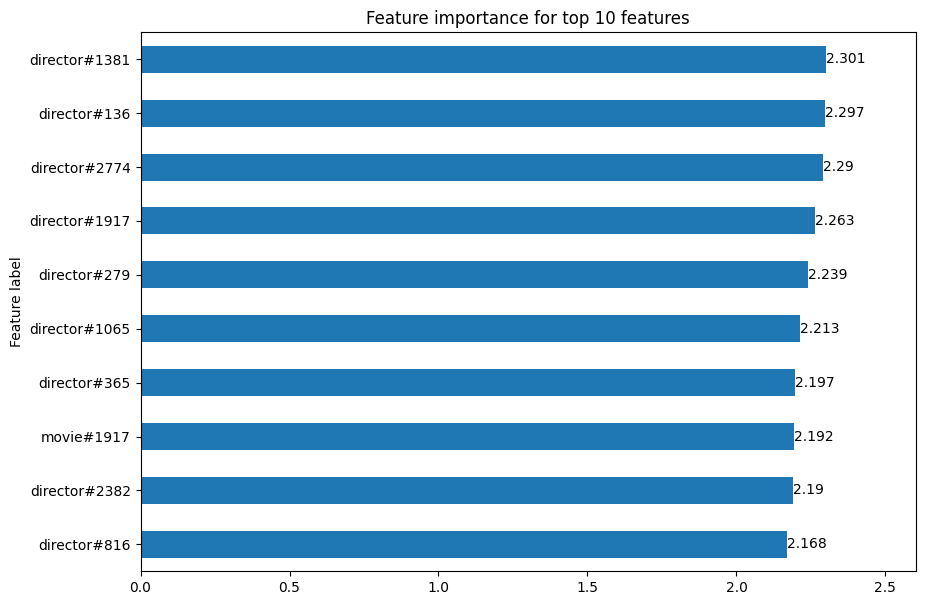

In [187]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

index = torch.tensor([486, 237])  # Explain edge labels with index 486 and 237.
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data['movie', 'director'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(top_k=10)

In [188]:
explanation.validate()

True

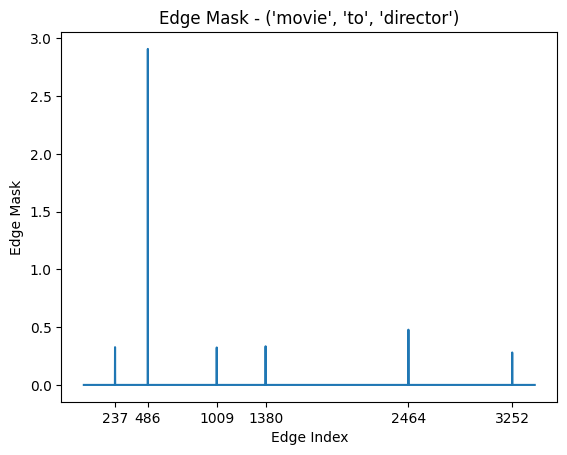

[ 237  486 1009 1380 2464 3252]


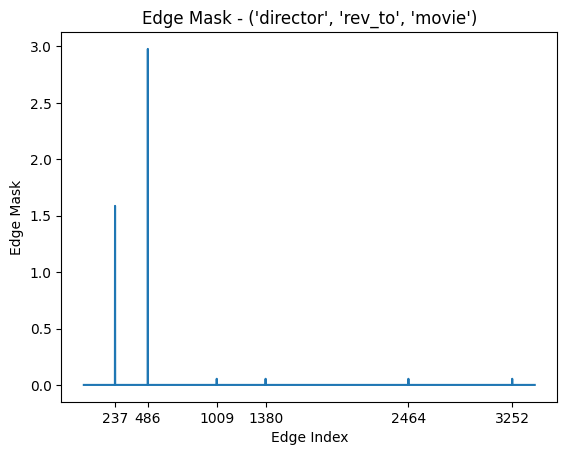

[ 237  486 1009 1380 2464 3252]


In [189]:
# Iterate over the edge types in the edge_mask_dict
for edge_type, edge_mask in explanation.edge_mask_dict.items():
    # Get the non-zero indices and values from the edge mask
    non_zero_indices = np.nonzero(edge_mask.cpu().detach().numpy())[0]
    non_zero_values = edge_mask[non_zero_indices].cpu().detach().numpy()

    # Plot the edge mask with non-zero indices
    plt.figure()
    plt.plot(edge_mask.cpu().detach().numpy())
    plt.xlabel('Edge Index')
    plt.ylabel('Edge Mask')
    plt.title(f'Edge Mask - {edge_type}')
    plt.xticks(non_zero_indices, non_zero_indices)
    plt.show()
    print(non_zero_indices)


Generated explanations in ['edge_mask', 'node_mask']


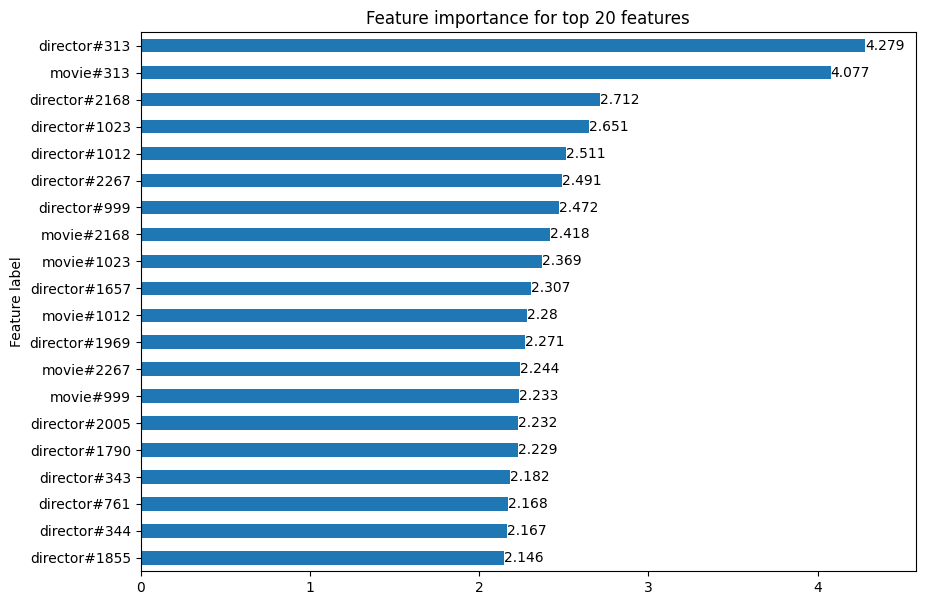

In [190]:
index = torch.tensor([0,1,2,3421,3422,3423])  # Explain edge labels with index 0,1,2,3421,3422 and 3423
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data['movie', 'director'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(top_k=20)

In [191]:
print(explanation.edge_mask_dict)

{('movie', 'to', 'director'): tensor([2.2684, 0.3591, 0.2499,  ..., 3.1541, 0.2438, 1.9215],
       dtype=torch.float64, grad_fn=<ViewBackward0>), ('director', 'rev_to', 'movie'): tensor([2.3312, 1.6729, 1.8906,  ..., 3.1635, 1.7495, 1.9963],
       dtype=torch.float64, grad_fn=<ViewBackward0>)}


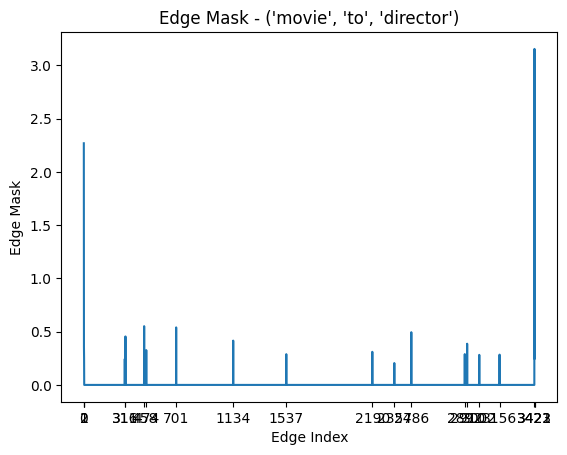

[   0    1    2  311  316  458  474  701 1134 1537 2190 2357 2486 2892
 2910 3002 3156 3421 3422 3423]


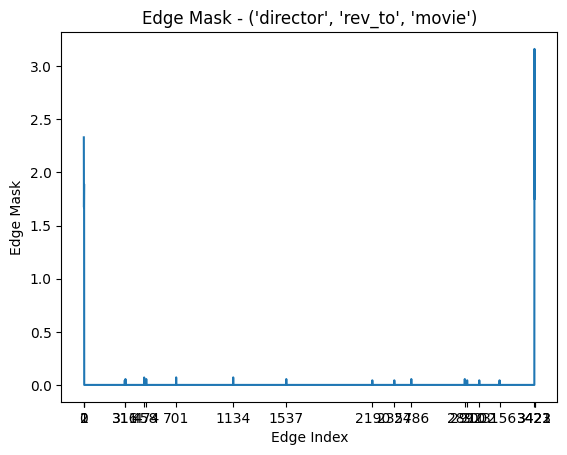

[   0    1    2  311  316  458  474  701 1134 1537 2190 2357 2486 2892
 2910 3002 3156 3421 3422 3423]


In [192]:
# Iterate over the edge types in the edge_mask_dict
for edge_type, edge_mask in explanation.edge_mask_dict.items():
    # Get the non-zero indices and values from the edge mask
    non_zero_indices = np.nonzero(edge_mask.cpu().detach().numpy())[0]
    non_zero_values = edge_mask[non_zero_indices].cpu().detach().numpy()

    # Plot the edge mask with non-zero indices
    plt.figure()
    plt.plot(edge_mask.cpu().detach().numpy())
    plt.xlabel('Edge Index')
    plt.ylabel('Edge Mask')
    plt.title(f'Edge Mask - {edge_type}')
    plt.xticks(non_zero_indices, non_zero_indices)
    plt.show()
    print(non_zero_indices)


Generated explanations in ['edge_mask', 'node_mask']


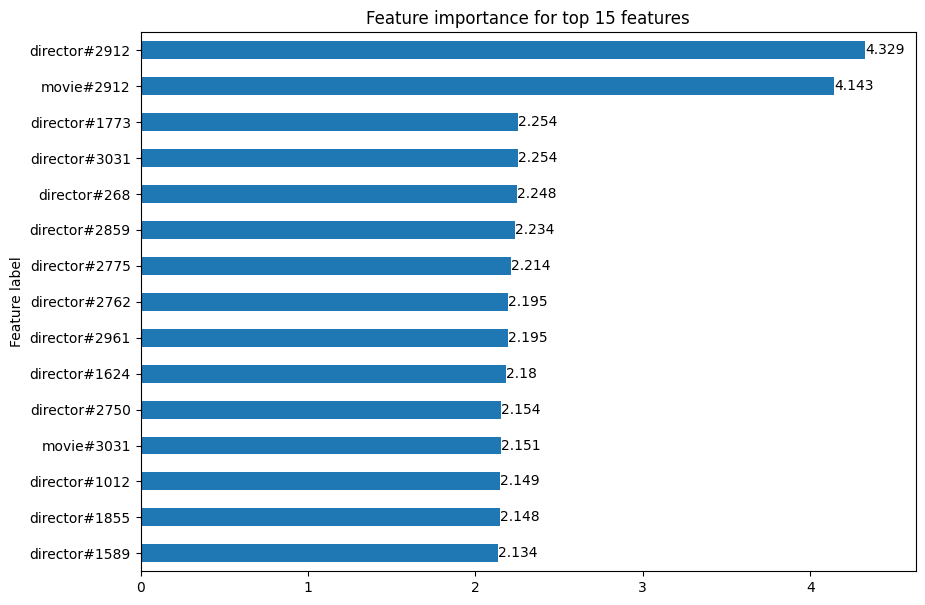

In [193]:
index = torch.tensor([678,999,82,12])  # Explain edge labels with index 678,999,82 and 12
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data['movie', 'director'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(top_k=15)

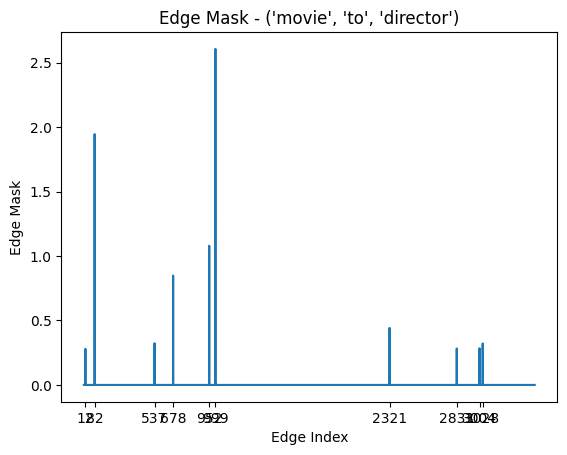

[  12   82  537  678  952  999 2321 2831 3004 3028]


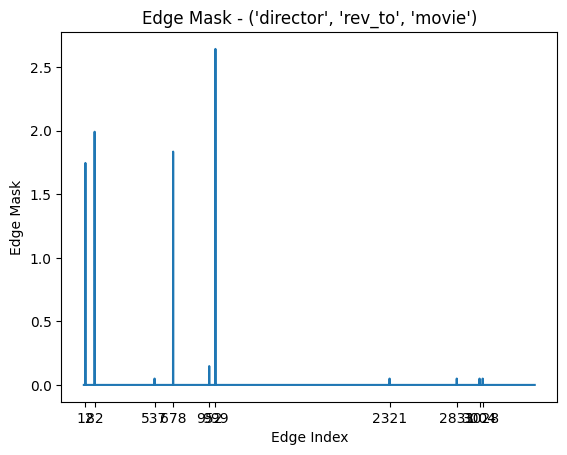

[  12   82  537  678  952  999 2321 2831 3004 3028]


In [194]:
# Iterate over the edge types in the edge_mask_dict
for edge_type, edge_mask in explanation.edge_mask_dict.items():
    # Get the non-zero indices and values from the edge mask
    non_zero_indices = np.nonzero(edge_mask.cpu().detach().numpy())[0]
    non_zero_values = edge_mask[non_zero_indices].cpu().detach().numpy()

    # Plot the edge mask with non-zero indices
    plt.figure()
    plt.plot(edge_mask.cpu().detach().numpy())
    plt.xlabel('Edge Index')
    plt.ylabel('Edge Mask')
    plt.title(f'Edge Mask - {edge_type}')
    plt.xticks(non_zero_indices, non_zero_indices)
    plt.show()
    print(non_zero_indices)


In [197]:
explanation.get_explanation_subgraph()

HeteroExplanation(
  prediction=[3424],
  target=[3424],
  index=[4],
  edge_label_index=[2, 3424],
  movie={
    node_mask=[10, 3066],
    x=[10, 3066],
  },
  director={
    node_mask=[4, 3066],
    x=[4, 3066],
  },
  (movie, to, director)={
    edge_mask=[10],
    edge_index=[2, 10],
  },
  (director, rev_to, movie)={
    edge_mask=[10],
    edge_index=[2, 10],
  }
)

In [198]:
explanation.get_complement_subgraph()

HeteroExplanation(
  prediction=[3424],
  target=[3424],
  index=[4],
  edge_label_index=[2, 3424],
  movie={
    node_mask=[4268, 3066],
    x=[4268, 3066],
  },
  director={
    node_mask=[2077, 3066],
    x=[2077, 3066],
  },
  (movie, to, director)={
    edge_mask=[3414],
    edge_index=[2, 3414],
  },
  (director, rev_to, movie)={
    edge_mask=[3414],
    edge_index=[2, 3414],
  }
)